In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split


In [2]:
system = "sevir_tem"
# 加载训练数据
x_train = np.load(f'/data5/chengjingwen/{system}/uv.npy')
x_train = torch.tensor(x_train, dtype=torch.float32)  # 转换为 Tensor
print(x_train.shape)

# 计算训练集的 min 和 max，维度为 (1, n_vars, 1, 1)
xmin = x_train.amin(dim=(0, 1, 3, 4), keepdim=True)  # 对轨迹数、时间步和空间维度求最小值
xmax = x_train.amax(dim=(0, 1, 3, 4), keepdim=True)  # 对轨迹数、时间步和空间维度求最大值


data = (x_train - xmin) / (xmax - xmin)


print(f"Training data normalized: min={data.min().item()}, max={data.max().item()}")

torch.Size([300, 49, 1, 128, 128])
Training data normalized: min=0.0, max=1.0


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class MultiStepInputDataset(Dataset):
    def __init__(self, data, history_steps=10):
        """
        data: Tensor, shape (num_trajectories, num_steps, num_variables, x_dim, y_dim)
        history_steps: how many past steps to use as input
        """
        self.data = data
        self.history_steps = history_steps
        self.num_trajectories, self.num_steps, self.num_variables, self.x_dim, self.y_dim = data.shape

        # 确保有足够时间步能取 history_steps + 1（因为input要10步，output是第11步）
        if self.num_steps <= self.history_steps:
            raise ValueError("num_steps must be greater than history_steps")

    def __len__(self):
        # 每条轨迹生成 (num_steps - history_steps) 个样本
        return self.num_trajectories * (self.num_steps - self.history_steps)

    def __getitem__(self, idx):
        # 确定轨迹编号和在轨迹内的起点时间步
        trajectory_idx = idx // (self.num_steps - self.history_steps)
        time_idx = idx % (self.num_steps - self.history_steps)

        # input: 连续 history_steps 个时间步，堆叠成channel
        input_sequence = self.data[trajectory_idx, time_idx : time_idx + self.history_steps]  # (history_steps, num_variables, x_dim, y_dim)
        input_data = input_sequence.reshape(-1, self.x_dim, self.y_dim)  # (history_steps*num_variables, x_dim, y_dim)

        # target: 预测的第 history_steps 后的一个时间步
        target_data = self.data[trajectory_idx, time_idx + self.history_steps]  # (num_variables, x_dim, y_dim)

        return input_data, target_data


train_data = data

train_dataset = MultiStepInputDataset(train_data, history_steps=10)

# 随机划分 80% train, 20% val
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 打印一个batch看看
for inputs, targets in train_loader:
    print(f"Input shape: {inputs.shape}, Target shape: {targets.shape}")
    num_variables = inputs.shape[1]
    break  # 只打印一次

Input shape: torch.Size([32, 20, 128, 64]), Target shape: torch.Size([32, 2, 128, 64])


In [3]:
from neuralop.models import FNO, TFNO

In [7]:
# import importlib.util

# spec = importlib.util.spec_from_file_location(
#     "neuralop.models.fno",
#     "/data4/chengjingwen/fno.py"
# )
# module = importlib.util.module_from_spec(spec)
# spec.loader.exec_module(module)

# # 导入 FNO
# FNO = module.FNO

In [17]:

# 初始化 FNO 模型
mode = 16
hidden_channels = 200
# 后面时间充裕的话，我们得做超参数搜索，channel：【32、64、128、256】、n_modes：【4，8，12，16，20】
T = 10
model = FNO(
    n_modes=(mode, mode),        # Fourier 模式的数量
    hidden_channels=hidden_channels,      # 隐藏层通道数
    in_channels=T,           # 输入变量数量（num_variables）
    out_channels=1         # 输出变量数量（num_variables）
)
device = "cuda:3"
model = model.to(device)
num_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {num_params / 1e6:.2f} M")

模型总参数量: 23.53 M


In [18]:
import torch.optim as optim

# 定义损失函数
loss_fn = torch.nn.MSELoss()

# 定义优化器


In [19]:
from tqdm import tqdm
num_epochs = 10
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 训练模型
for epoch in range(num_epochs):
    model.train()  # 切换到训练模式
    epoch_loss = 0.0

    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # 清空梯度

        
        predictions = model(inputs)

      
        loss = loss_fn(predictions, targets)

       
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4e}")

100%|██████████| 293/293 [01:03<00:00,  4.65it/s]


Epoch 1/10, Loss: 4.5560e-03


100%|██████████| 293/293 [00:48<00:00,  6.00it/s]


Epoch 2/10, Loss: 7.6651e-04


100%|██████████| 293/293 [00:53<00:00,  5.45it/s]


Epoch 3/10, Loss: 7.5069e-04


100%|██████████| 293/293 [00:50<00:00,  5.75it/s]


Epoch 4/10, Loss: 7.1194e-04


100%|██████████| 293/293 [00:54<00:00,  5.41it/s]


Epoch 5/10, Loss: 7.2340e-04


100%|██████████| 293/293 [00:51<00:00,  5.74it/s]


Epoch 6/10, Loss: 6.8738e-04


100%|██████████| 293/293 [00:54<00:00,  5.38it/s]


Epoch 7/10, Loss: 6.3579e-04


100%|██████████| 293/293 [00:47<00:00,  6.14it/s]


Epoch 8/10, Loss: 6.3136e-04


  3%|▎         | 9/293 [00:01<00:51,  5.56it/s]


KeyboardInterrupt: 

In [20]:
# save_path = f"/data3/chengjingwen/diffusion-mdpnet/trained_model/baseline/{system}/fno_{mode}_{hidden_channels}.pth"
# torch.save(model.state_dict(), save_path)

In [5]:
# test
T = 10
system = "sevir_tem"
mode = 16
hidden_channels = 200
model = FNO(
    n_modes=(mode, mode),        # Fourier 模式的数量
    hidden_channels=hidden_channels,      # 隐藏层通道数
    in_channels=T,           # 输入变量数量（num_variables）
    out_channels=1          # 输出变量数量（num_variables）
)
device = "cuda:2"
model.load_state_dict(torch.load(f'/data3/chengjingwen/diffusion-mdpnet/trained_model/baseline/{system}/fno_{mode}_{hidden_channels}.pth'))
model.to(device)
model.eval()  # 切换到推理模式

/tmp/ipykernel_402236/2811483357.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/data3/chengjingwen/diffusion-mdpnet/trained_model/b

FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([200, 200, 16, 9]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(200, 200, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(200, 100, kernel_size=(1,), stride=(1,))
          (1): Conv1d(100, 200, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(12, 400, kernel_size=(1,), stride=(1,))
      (1): Conv1d(400, 200, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(200, 400, kernel_size=(1,), stride=(1,))
      (1): Conv1d(400, 1

In [6]:
import torch
import numpy as np

system = "sevir_tem"
x_test = np.load(f'/data5/chengjingwen/{system}/uv_test.npy')
x_test = torch.tensor(x_test, dtype=torch.float32)  # 转换为 Tensor
# x_test = clip(x_test)
x_test_normalized = (x_test - xmin) / (xmax - xmin)

print(f"Test data normalized: min={x_test_normalized.min().item()}, max={x_test_normalized.max().item()}")

Test data normalized: min=0.0, max=0.913608968257904


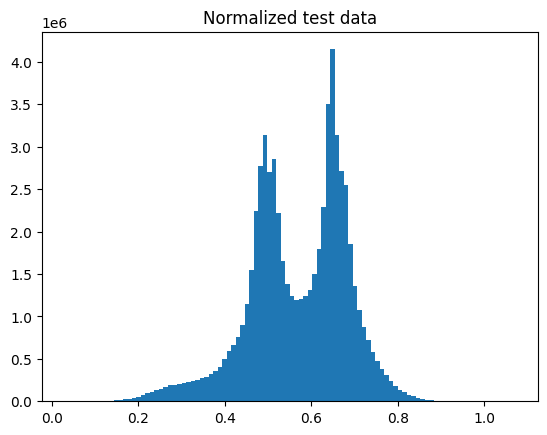

In [5]:
import matplotlib.pyplot as plt
plt.hist(x_test_normalized.flatten(), bins=100)
plt.title("Normalized test data")
plt.show()

In [11]:
import numpy as np
import torch
from torchmetrics.functional import structural_similarity_index_measure as ssim
import matplotlib.pyplot as plt
from IPython.display import clear_output

pred_step = 10
start_time = 20

def compute_nmse(predictions, targets):
    """计算 NMSE"""
    return torch.mean(((predictions - targets) ** 2)) / torch.mean((targets ** 2))

def compute_rmse(predictions, targets):
    """计算 RMSE"""
    mse = torch.mean((predictions - targets) ** 2)
    return torch.sqrt(mse)

device = "cuda:2"

# model.to(device)
test_data = x_test_normalized.to(device)[:1]




model.eval()
num_trajectories, T, num_variables, x_dim, y_dim = test_data.shape

nmse_list = []
ssim_list = []
rmse_list = []

for trajectory_idx in range(num_trajectories):
    print(f"now for {trajectory_idx}")
    trajectory = test_data[trajectory_idx]  # shape [100, num_variables, x_dim, y_dim]
    print(trajectory.shape)
    
    truth = trajectory[start_time :start_time + pred_step].to(device)  # 未来 10 步
    print(truth.shape)

    # 初始化
    predictions = torch.zeros((pred_step, num_variables, x_dim, y_dim)).to(device)

    for t in range(pred_step):
        if t == 0:
            input_data = trajectory[start_time-10 :start_time].reshape(-1, x_dim, y_dim).unsqueeze(0).to(device)  # 起始时间的输入  # (1, 10*2 128, 128)
        # else:
        #     input_data = predictions[t - 1].unsqueeze(0)  # 前一帧的预测作为输入
        predictions[t] = model(input_data)  # (1, 2, 128, 128)
        input_data = input_data[:, num_variables:]
        input_data = torch.cat([input_data, predictions[t:t+1]], dim = 1)

    # 计算 SSIM
    ssim_values = ssim(predictions, truth, data_range=1.0).item()

    # 计算 NMSE
    nmse_trajectory = compute_nmse(predictions, truth).item()

    # 计算 RMSE
    rmse_trajectory = compute_rmse(predictions, truth).item()

    nmse_list.append(nmse_trajectory)
    ssim_list.append(ssim_values)
    rmse_list.append(rmse_trajectory)

# 汇总结果
nmse_mean, nmse_std = np.mean(nmse_list), np.std(nmse_list)
ssim_mean, ssim_std = np.mean(ssim_list), np.std(ssim_list)
rmse_mean, rmse_std = np.mean(rmse_list), np.std(rmse_list)

channel = 0
for t in range(pred_step):
    plt.figure(figsize=(12, 4))

    # Ground Truth
    plt.subplot(131)
    plt.title(f"Ground Truth (step={ t + 1})")
    plt.imshow(truth[t, channel].cpu().numpy(), cmap="coolwarm", vmin=0, vmax=1)
    plt.colorbar()

    # Prediction
    plt.subplot(132)
    plt.title("Prediction")
    plt.imshow(predictions[t, channel].detach().cpu().numpy(), cmap="coolwarm", vmin=0, vmax=1)
    plt.colorbar()

    # Difference and MSE
    nmse = compute_nmse(truth[t:t+1], predictions[t:t+1]).item()
    plt.subplot(133)
    plt.title(f"Difference (NMSE={nmse:.5f})")
    plt.imshow(torch.abs(truth[t, channel] - predictions[t, channel].detach()).cpu().numpy(), cmap="coolwarm")
    plt.colorbar()

    plt.show()
    clear_output(wait=True)  # 显示当前时间步，清除上一时间步
# #     # end = time.time()
# #     # print(end-start)




print(f"{n}")
# print(f"NMSE Mean: {results['NMSE_mean']}")
# print(f"NMSE Std: {results['NMSE_std']}")
print(f"SSIM Mean: {results['SSIM_mean']}")
# print(f"SSIM Std: {results['SSIM_std']}")
print(f"RMSE Mean: {results['RMSE_mean']}")
# print(f"RMSE Std: {results['RMSE_std']}")


# 遍历测试集
# with torch.no_grad():
#     # start = time.time()
#     for trajectory_idx, trajectory in enumerate(test_data):  # 假设 test_data 包含完整轨迹
#         # start_step = np.random.randint(0, 40)  # 随机选取起始时间步
#         start_step = 0
#         # trajectory 的形状: (num_steps, num_variables, x_dim, y_dim)
#         trajectory = trajectory.to(device)

#         # 初始条件（从指定的时间步开始）
#         initial_condition = trajectory[start_step:start_step + 1]  # (1, num_variables, x_dim, y_dim)
#         future_truth = trajectory[start_step + 1:start_step + 1 + lookahead_steps]  # 真值
#         future_pred = []  # 存储预测结果

#         # 自回归预测
#         for t in range(lookahead_steps):
#             # 使用模型预测
#             prediction = model(initial_condition)  # 输出 (1, num_variables, x_dim, y_dim)
#             future_pred.append(prediction.squeeze(0))  # 存储预测结果（保持在 GPU 上）

#             # 更新初始条件（滚动窗口）
#             initial_condition = prediction  # 用预测值作为下一步输入

#         # 转换预测结果为张量
#         future_pred = torch.stack(future_pred, dim=0)  # (lookahead_steps, num_variables, x_dim, y_dim)
#         frames = []
#         # 可视化结果
#         channel = 0
#         vmin, vmax = future_truth[:, channel].min(), future_truth[:, channel].max()
channel = 0


NameError: name 'n' is not defined

In [12]:
print(predictions.shape)

torch.Size([10, 1, 128, 128])


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# 转换为 numpy
# tru_np = tru.cpu().numpy()[0] if hasattr(tru, 'cpu') else tru
pred_np = predictions.detach().cpu().numpy()[0,0]
# reconstruct_np = reconstructed.cpu().numpy()[0, 0]
# sparse_np = sparse_tensor.cpu().numpy()[0, 0]

# 通用保存函数
def save_image(array, path, cmap='coolwarm', mask_zeros=False):
    fig, ax = plt.subplots(figsize=(6, 6))

    if mask_zeros:
        array = np.where(array == -1, np.nan, array)
        cmap_with_nan = plt.get_cmap(cmap).copy()
        cmap_with_nan.set_bad(color='white')
        im = ax.imshow(array, cmap=cmap_with_nan)
    else:
        im = ax.imshow(array, cmap=cmap)

    ax.axis('off')
    plt.tight_layout()
    plt.savefig(path, format='pdf', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()

# 保存为 PDF
# save_image(tru_np,         "/data3/chengjingwen/diffusion-mdpnet/figures/climate_tru.pdf")
save_image(pred_np,        "/data3/chengjingwen/diffusion-mdpnet/figures/climate_fno.pdf")
# save_image(reconstruct_np, "/data3/chengjingwen/diffusion-mdpnet/figures/1024-reconstruct.pdf")
# save_image(sparse_np,      "/data3/chengjingwen/diffusion-mdpnet/figures/1024-sparse.pdf", mask_zeros=True)

In [12]:
import numpy as np
import torch
from torchmetrics.functional import structural_similarity_index_measure as ssim
import matplotlib.pyplot as plt
from IPython.display import clear_output

pred_step = 130
start_time = 20

def compute_nmse(predictions, targets):
    """计算 NMSE"""
    return torch.mean(((predictions - targets) ** 2)) / torch.mean((targets ** 2))

def compute_rmse(predictions, targets):
    """计算 RMSE"""
    mse = torch.mean((predictions - targets) ** 2)
    return torch.sqrt(mse)

def compute_pearson(pred, target):
    """逐帧计算 Pearson 相关系数，输入形状 (T, C, H, W)"""
    T = pred.shape[0]
    pearson_scores = []

    for t in range(T):
        x = pred[t].reshape(-1).detach()
        y = target[t].reshape(-1).detach()
        x_mean = x.mean()
        y_mean = y.mean()
        cov = ((x - x_mean) * (y - y_mean)).mean()
        std_x = x.std()
        std_y = y.std()
        corr = cov / (std_x * std_y + 1e-8)
        pearson_scores.append(corr.item())

    return pearson_scores

def test_model(model, test_data, device):
    model.eval()
    num_trajectories, T, num_variables, x_dim, y_dim = test_data.shape

    nmse_list = []
    ssim_list = []
    rmse_list = []

    pearson_all = []
    high_corr_time_09 = []
    high_corr_time_08 = []

    for trajectory_idx in range(num_trajectories):
        print(f"now for {trajectory_idx}")
        trajectory = test_data[trajectory_idx]  # shape [T, C, H, W]
        truth = trajectory[start_time :start_time + pred_step].to(device)
        predictions = torch.zeros((pred_step, num_variables, x_dim, y_dim)).to(device)

        for t in range(pred_step):
            if t == 0:
                input_data = trajectory[start_time-10 :start_time].reshape(-1, x_dim, y_dim).unsqueeze(0).to(device)
            predictions[t] = model(input_data)
            input_data = input_data[:, num_variables:]
            input_data = torch.cat([input_data, predictions[t:t+1]], dim=1)

        # 计算三种指标
        ssim_values = ssim(predictions, truth, data_range=1.0).item()
        nmse_trajectory = compute_nmse(predictions, truth).item()
        rmse_trajectory = compute_rmse(predictions, truth).item()

        nmse_list.append(nmse_trajectory)
        ssim_list.append(ssim_values)
        rmse_list.append(rmse_trajectory)

        # 计算 Pearson 并记录高相关时间
        pearson_scores = compute_pearson(predictions, truth)
        pearson_all.append(pearson_scores)

        threshold_09 = next((i for i, val in enumerate(pearson_scores) if val < 0.9), pred_step)
        threshold_08 = next((i for i, val in enumerate(pearson_scores) if val < 0.8), pred_step)
        high_corr_time_09.append(threshold_09)
        high_corr_time_08.append(threshold_08)

    # 汇总
    nmse_mean, nmse_std = np.mean(nmse_list), np.std(nmse_list)
    ssim_mean, ssim_std = np.mean(ssim_list), np.std(ssim_list)
    rmse_mean, rmse_std = np.mean(rmse_list), np.std(rmse_list)

    pearson_all = np.array(pearson_all)  # (N, T)
    print("pearson", pearson_all)
    pearson_mean = pearson_all.mean(axis=0)
    corr_t_09 = np.mean(high_corr_time_09)
    corr_t_08 = np.mean(high_corr_time_08)

    print(f"\n===== Summary =====")
    print(f"NMSE Mean: {nmse_mean:.5f}, Std: {nmse_std:.5f}")
    print(f"SSIM Mean: {ssim_mean:.5f}, Std: {ssim_std:.5f}")
    print(f"RMSE Mean: {rmse_mean:.5f}, Std: {rmse_std:.5f}")
    print(f"High Corr Time @0.9: {corr_t_09:.1f} steps")
    print(f"High Corr Time @0.8: {corr_t_08:.1f} steps")
    print(f"====================\n")

    return {
        "NMSE_mean": nmse_mean,
        "NMSE_std": nmse_std,
        "SSIM_mean": ssim_mean,
        "SSIM_std": ssim_std,
        "RMSE_mean": rmse_mean,
        "RMSE_std": rmse_std,
        "Pearson_mean_curve": pearson_mean,
        "HighCorrTime@0.9": corr_t_09,
        "HighCorrTime@0.8": corr_t_08,
    }


# model.to(device)
test_data = x_test_normalized.to(device)


results = test_model(model, test_data[:1], device)



now for 0
pearson [[0.99887443 0.99783999 0.9967885  0.99583489 0.99486423 0.99399883
  0.99316019 0.99238175 0.99215251 0.99135578 0.98947114 0.98593551
  0.98036349 0.97195631 0.96060216 0.94860786 0.93750995 0.92972243
  0.9259547  0.92431873 0.92191046 0.91748416 0.91095197 0.90151185
  0.88972306 0.87689245 0.86346185 0.84769338 0.82701719 0.80644381
  0.78988457 0.77987641 0.77570903 0.77733082 0.77675825 0.7687633
  0.75689888 0.74441993 0.73296648 0.72293723 0.71521026 0.70994961
  0.7061131  0.70715117 0.71036911 0.7162832  0.72489393 0.73393869
  0.74180114 0.7449041  0.74473834 0.74171108 0.73331869 0.72491974
  0.73225683 0.75414211 0.77214408 0.78287303 0.79105973 0.79621935
  0.7929849  0.78140533 0.76455235 0.74704546 0.73270893 0.72094369
  0.71036834 0.69457591 0.6746884  0.65252405 0.62487882 0.59539419
  0.56284738 0.50965738 0.44257477 0.39441529 0.36883157 0.34940261
  0.32663321 0.30052802 0.27643552 0.25314674 0.23080382 0.2117622
  0.17921217 0.11826771 0.058552

In [ ]:
for t in range(pred_step):
        plt.figure(figsize=(12, 4))

        # Ground Truth
        plt.subplot(131)
        plt.title(f"Ground Truth (step={ t + 1})")
        plt.imshow(truth[t, channel].cpu().numpy(), cmap="coolwarm", vmin=0, vmax=1)
        plt.colorbar()

        # Prediction
        plt.subplot(132)
        plt.title("Prediction")
        plt.imshow(predictions[t, channel].detach().cpu().numpy(), cmap="coolwarm", vmin=0, vmax=1)
        plt.colorbar()

        # Difference and MSE
        nmse = compute_nmse(truth[t:t+1], predictions[t:t+1]).item()
        plt.subplot(133)
        plt.title(f"Difference (NMSE={nmse:.5f})")
        plt.imshow(torch.abs(truth[t, channel] - predictions[t, channel].detach()).cpu().numpy(), cmap="coolwarm")
        plt.colorbar()

        plt.show()
        clear_output(wait=True)  # 显示当前时间步，清除上一时间步

In [31]:
print(targets.shape)

torch.Size([32, 2, 128, 128])


torch.Size([1, 100, 2, 128, 128])


NameError: name 'truth' is not defined

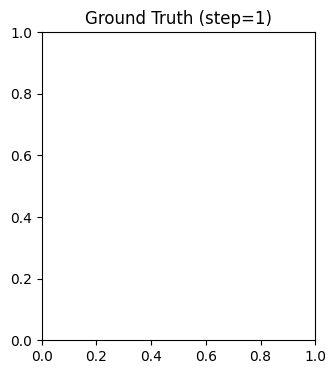